In [1]:
# Importation of liberies.
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy.interpolate import pchip_interpolate
from scipy import interpolate, signal

In [2]:
# Functions
#_______________________________________________________________________________
def Load_Files(dir):
    data={}
    entries = os.listdir(dir)
    titles= ['Sensor','TimeStamp','Roll','Pitch','Yaw','xGyr','yGyr','zGyr','BatteryLVL']
    for i in entries:
        if 'SENSOR'in i:
            name= i.split('.')
            s = pd.read_csv(dir + i, sep=",")
            s.columns= titles
            s['TimeStamp']= s['TimeStamp']/1000
            data[name[0]] = s
    return data
#_______________________________________________________________________________
def Plot_Data(data):
  """
  This fuction plot the Roll, Pitch and Yaw data.
  """

  fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(10,15))
  for i in data:
    s= data[i]
    ax1.plot(s['TimeStamp'],s['Roll'], label= i)
    ax2.plot(s['TimeStamp'],s['Pitch'], label= i)
    ax3.plot(s['TimeStamp'],s['Yaw'], label= i)
  ax1.set_xlabel('Time (s)')
  ax1.set_ylabel('Roll (°)')
  ax1.set_title('Roll')
  ax1.legend()
  ax2.set_xlabel('Time (s)')
  ax2.set_ylabel('Pitch (°)')
  ax2.set_title('Pitch')
  ax2.legend()
  ax3.set_xlabel('Time (s)')
  ax3.set_ylabel('Yaw (°)')
  ax3.set_title('Yaw')
  ax3.legend()
  plt.show()
  return None
#_______________________________________________________________________________
def Set_Data(data):
  """
  This fuction set the sensors to start in 0.
  """
  for i in data:
    s= data[i]
    s= s.iloc[50:data[i].size-29,:]                                             #errase first 50 takes and last 29
    time= s["TimeStamp"]
    time= time-time.iloc[0]
    s['TimeStamp']= time
    data[i]= s
  return data 
#_______________________________________________________________________________
def Change_Range(data,thresh=89):
  """
  This fuction fix the angles lokking for the abrupt changes.
  """
  for s in data:
    new_data= data[s].iloc[:,2:6]
    for d in new_data.columns:
      var= new_data[d]
      drv= np.where(((abs(var.diff()))>=thresh))
      drv=drv[0].tolist()
      for f in range(0,(len(drv)//2)):
      if ((len(drv)//2) % 2) != 0: 
        chg= var.iloc[drv[-1]-1]+var.iloc[drv[-1]]
        var.iloc[drv[-1]:]=-(var.iloc[drv[-1]:])+chg
      new_data[d]=var
    data[s].iloc[:,2:6]= new_data
  return data
#_______________________________________________________________________________
def Resample(data, f):
  """
  This fuction resample the data to a frecuency passed by the user.
  """
  for i in data:
    s= data[i]
    n_t= s.loc[:,'TimeStamp']
    n_t= n_t-n_t.iloc[0]
    n_t= np.linspace(0,n_t.iloc[-1], round(n_t.iloc[-1]*f))
    r= s['Roll']
    p= s['Pitch']
    h= s['Yaw']
    x= s['xGyr']
    y= s['yGyr']
    z= s['zGyr']
    r= pchip_interpolate(s['TimeStamp'],r,n_t)
    p= pchip_interpolate(s['TimeStamp'],p,n_t)
    h= pchip_interpolate(s['TimeStamp'],h,n_t)
    x= pchip_interpolate(s['TimeStamp'],x,n_t)
    y= pchip_interpolate(s['TimeStamp'],y,n_t)
    z= pchip_interpolate(s['TimeStamp'],z,n_t)
    s= pd.DataFrame({'TimeStamp':n_t, 'Roll':r, 'Pitch':p, 'Yaw':h, 'xGyr':x, 'yGyr':y, 'zGyr':z})
    data[i]= s
  return data
#_______________________________________________________________________________
def Syncronize(data):
  """
  This function synchronizes the sensors and returns the synchronized data using cross correlation lag.
  """
  #Find the shortest sesnor.
  n= list(data.keys())
  l= len(data[n[0]])
  ref= n[0]
  for i in range(1,len(n)):
    if len(data[n[i]])<l:
      l= len(data[n[i]])
      ref= n[i]
  s_ref= data[n[i]].iloc[:,4:8]
  delay={}
  delay[ref]= 0
  inc=0

  #Find the delay between the sensors.
  for s in data:
    if s != ref:
      sensor= data[s].iloc[:,4:8]
      for c in sensor.columns:
        m_corr=0
        corr= signal.correlate(s_ref[c],sensor[c], mode='full', method='fft')
        lags = signal.correlation_lags(s_ref[c].size, sensor[c].size, mode="full")
        if np.argmax(corr)>m_corr: 
          lag = lags[np.argmax(corr)]
      if lag<inc:inc= lag
      delay[s]= lag
  #Aplay the delay to the data.
  for s in data:
    data[s]= data[s].iloc[delay[s]-inc:,:]
    time= data[s]['TimeStamp']
    time= time-time.iloc[0]
    data[s]['TimeStamp']= time
  return data
#_______________________________________________________________________________
def Rotation_Matrix(Roll, Pitch, Yaw):
  """ 
  This fuction determine the Rotation Matrix from the Euler Angles 
  (Roll, Pitch, Yaw) with the XYZ convention of the sensors.
  """
  R_x = np.array([[1, 0, 0],
                  [0, np.cos(Roll), -np.sin(Roll)],
                  [0, np.sin(Roll), np.cos(Roll)]])
  R_y = np.array([[np.cos(Pitch), 0, np.sin(Pitch)],
                  [0, 1, 0],
                  [-np.sin(Pitch), 0, np.cos(Pitch)]])
  R_z = np.array([[np.cos(Yaw), -np.sin(Yaw), 0],
                  [np.sin(Yaw), np.cos(Yaw), 0],
                  [0, 0, 1]])
  R = np.dot(R_z, np.dot(R_y, R_x))
  return R
#_______________________________________________________________________________
def Get_Rotation_Matrix(data):
  """
  This fuction determine the Rotation Matrix from the Euler Angles 
  (Roll, Pitch, Heading) with the XYZ convention of the sensors.
  """
  Rot_Mtx={}
  for i in data:
    s= data[i]
    R= np.zeros((len(s),3,3))
    for j in range(0,len(s)):
      R[j,:,:]= Rotation_Matrix(s.iloc[j,1],s.iloc[j,2],s.iloc[j,3])
    Rot_Mtx[i]= R
  return Rot_Mtx


C:\Users\Jose Amorocho\AppData\Local\Temp\ipykernel_33172\2673401811.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['TimeStamp']= time


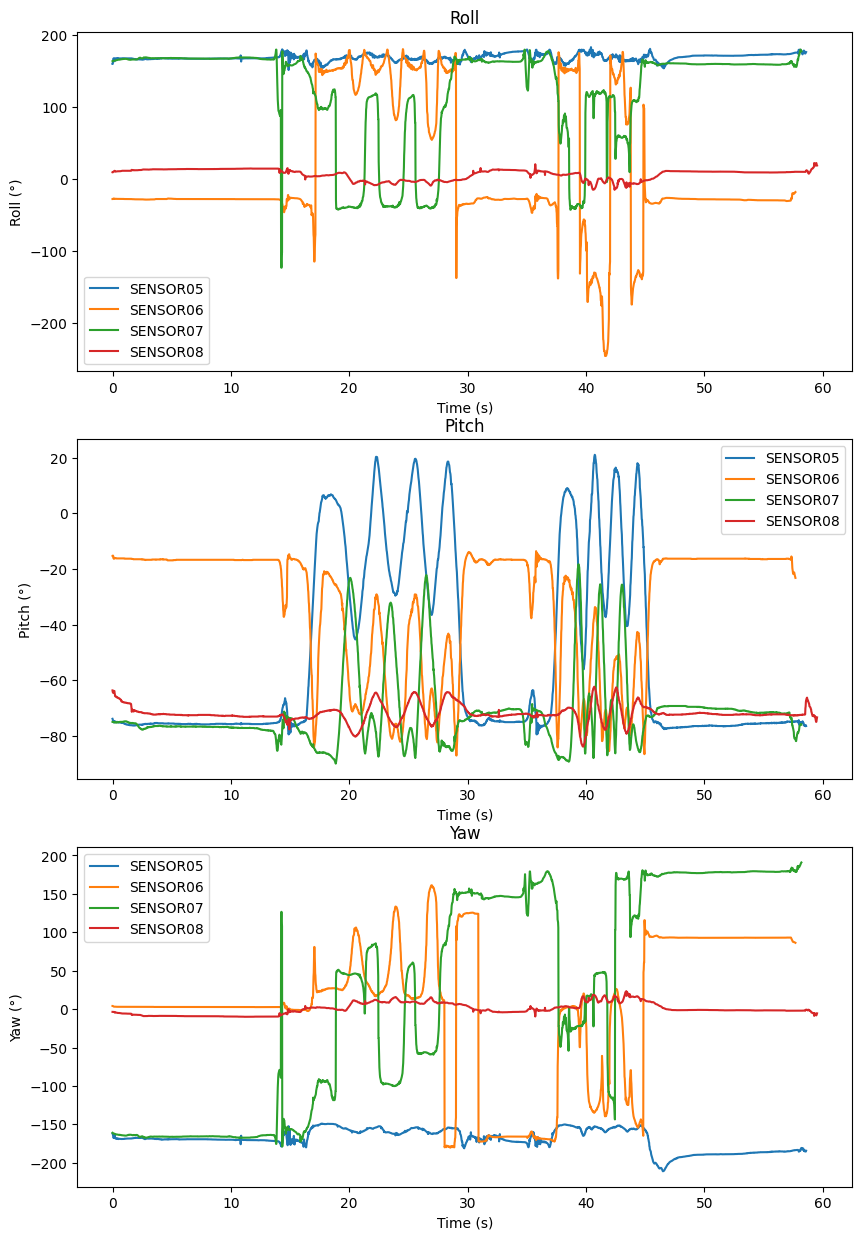

In [31]:
#test= input('put the name test:')
test= 'FECad_p1'
dir="D:/_Proyecto-SAM/2022-02-01/"+test+'/'

# Load the data
data= Load_Files(dir)
# Set Start to 0 Sensors(SAM).
data= Set_Data(data)
data= Change_Range(data, 0.5)
Plot_Data(data)

In [22]:
thresh=89
s= 'SENSOR05'




In [23]:
n_d.diff()

,Roll,Pitch,Yaw
50,NaN,NaN,NaN
51,0.0,-0.2,-0.3
52,2.3,-0.4,-1.8
53,1.4,-0.4,-1.1
54,3.5,0.0,-2.2
...,...,...,...
2953,0.2,-0.1,0.0
2954,-0.2,0.0,0.1
2955,-0.5,0.1,0.1
2956,-0.7,0.2,-0.1


In [ ]:
chg_r= var.iloc[drv[f*2]-1]+var.iloc[drv[f*2]]
var.iloc[drv[f*2]:drv[(f*2)+1]]=-(var.iloc[drv[f*2]:drv[(f*2)+1]])+chg

In [29]:
for s in data:
  n_d= data[s].loc[:,('Roll','Pitch','Yaw')]
  drv= (abs(n_d.diff())>=thresh)
  r= (drv[drv['Roll']==True].index).tolist()
  p= (drv[drv['Pitch']==True].index).tolist()
  y= (drv[drv['Yaw']==True].index).tolist()
  if (len(r) % 2) != 0: r.append(len(n_d)-1)
  if (len(p) % 2) != 0: p.append(len(n_d)-1)
  if (len(y) % 2) != 0: y.append(len(n_d)-1)
  for i in range(0,max([len(r),len(p),len(y)])-1,2):
    if i <= len(r):
      chg_r= n_d['Roll'][r[0]]-n_d['Roll'][r[0]-1]
      n_d['Roll'][r[i]:r[i+1]-1]=-(n_d['Roll'][r[i]:r[i+1]-1])-chg_r
    if i <= len(p):
      chg_p= n_d['Pitch'][r[0]]-n_d['Pitch'][r[0]-1]
      n_d['Pitch'][r[i]:r[i+1]-1]=-(n_d['Pitch'][r[i]:r[i+1]-1])-chg_p
    if i <= len(y):
      chg_y= n_d['Yaw'][r[0]]-n_d['Yaw'][r[0]-1]
      n_d['Yaw'][r[i]:r[i+1]-1]=-(n_d['Yaw'][r[i]:r[i+1]-1])-chg_y
  

ValueError: cannot set using a slice indexer with a different length than the value

In [ ]:

# Set Start to 0 Sensors(SAM).
data= Set_Data(data)
# Adjust angles range -180 to 180 to a continous angles.
data= Change_Range(data,150)
# Over-sample to 200Hz.
data= Resample(data,200)
# Syncronize the data.
data= Syncronize(data)
# Sample to 50Hz.
data= Resample(data,50)
# Get the Rotation Matrix.
Rot_Mtx= Get_Rotation_Matrix(data)

Plot_Data(data)